# Assignment 2: Milestone I Natural Language Processing
## Task 2&3
#### Student Name: Amay Iyer
#### Student ID: 3970066

Date: October 6, 2023

Version: 1.0

Environment: Python 3 and Jupyter notebook

Libraries used: please include all the libraries you used in your assignment, e.g.,:
* pandas
* re
* numpy
* re
* sklearn
* nltk
* gensim

## Introduction
For this task, I followed the meticulous guidelines outlined in the Assignment document. I first tokenized and counted the vectors for parsing into the Language model so I can evaluate their effectiveness & accuracy in being a good representative of the data.

## Importing libraries 

In [75]:
# Code to import libraries that I need in this assessment, e.g.,
import numpy as np
import pandas as pd
import re
import os


In [76]:
from nltk.tokenize import RegexpTokenizer
from sklearn.feature_extraction.text import TfidfVectorizer


In [77]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.metrics import accuracy_score, classification_report


In [78]:
# !pip install gensim 
!pip install gensim

In [79]:
import gensim
from gensim.models import Word2Vec, KeyedVectors


## Task 2. Generating Feature Representations for Job Advertisement Descriptions

...... Sections and code blocks on buidling different document feature represetations


<span style="color: red"> You might have complex notebook structure in this section, please feel free to create your own notebook structure. </span>

In [80]:
# Coding to import libraries as you need in this assessment, e.g.,
# Importing required libraries
import os
import pandas as pd
import re

# For NLP tasks
from nltk.tokenize import RegexpTokenizer


In [81]:
# Code to inspect the provided data file...
# Defining a function to extract data from each job advertisement
def extract_data_from_folder(base_path):
    data = []
    
    # List all category folders
    categories = os.listdir(base_path)
    
    for category in categories:
        category_path = os.path.join(base_path, category)
        
        # Making sure I'm looking only at folders and not stray files
        if os.path.isdir(category_path):
            files = os.listdir(category_path)
            
            for file in files:
                file_path = os.path.join(category_path, file)
                
                with open(file_path, 'r', encoding='utf-8') as f:
                    # Typically, the description is the entire content after the webindex
                    content = f.read()
                    # A simple regex split could help segregate title, webindex, and description, 
                    #but here I'll consider the entire content for simplicity and later tokenize it using 
                    #the regex in subsequent cells
                    data.append([category, file.split('.')[0], content])
                    
    return pd.DataFrame(data, columns=['Category', 'Job_ID', 'Content'])

# Assuming the base path is 'data'
base_path = 'data'
df = extract_data_from_folder(base_path)

# displaying the first few rows of the dataframe
print(df.head())


  Category     Job_ID                                            Content
0    Sales  Job_00776  Title: Estate Agency Senior Sales Negotiator\n...
1    Sales  Job_00762  Title: Export Sales Executive (French & German...
2    Sales  Job_00763  Title: GRADUATE SALES ENGINEER\nWebindex: 6825...
3    Sales  Job_00749  Title: Sales Representative / Lead Generator\n...
4    Sales  Job_00761  Title: Search Recruitment Consultant  Media an...


In [82]:
import os
import pandas as pd
import re
import numpy as np
import gensim.downloader as api
from sklearn.feature_extraction.text import TfidfVectorizer

# Code to inspect the provided data file...
# Defining a function to extract data from each job advertisement
def extract_data_from_folder(base_path):
    data = []
    
    # List all category folders
    categories = os.listdir(base_path)
    
    for category in categories:
        category_path = os.path.join(base_path, category)
        
        # Making sure I'm looking only at folders and not stray files
        if os.path.isdir(category_path):
            files = os.listdir(category_path)
            
            for file in files:
                file_path = os.path.join(category_path, file)
                
                with open(file_path, 'r', encoding='utf-8') as f:
                    # Typically, the description is the entire content after the webindex
                    content = f.read()
                    # A simple regex split could help segregate title, webindex, and description, 
                    #but here I'll consider the entire content for simplicity and later tokenize it using 
                    #the regex in subsequent cells content for simplicity
                    data.append([category, file.split('.')[0], content])
                    
    return pd.DataFrame(data, columns=['Category', 'Job_ID', 'Content'])

# Assuming the base path is 'data' and displaying the df
base_path = 'data'
df = extract_data_from_folder(base_path)

# Tokenization Function using the provided regular expression
def tokenize(text):
    return re.findall(r"[a-zA-Z]+(?:[-'][a-zA-Z]+)?", text)

# Tokenizing the 'Content' column
df['Tokens'] = df['Content'].apply(tokenize)

# Loading the vocabulary from vocab.txt
with open("vocab.txt", "r") as file:
    vocab_lines = file.readlines()

vocab_dict = {line.split(":")[0]: int(line.split(":")[1].strip()) for line in vocab_lines}

# Generating count vectors
def generate_count_vector(tokens):
    count_vector = {word: tokens.count(word) for word in set(tokens) if word in vocab_dict}
    return count_vector

df['Count_Vector'] = df['Tokens'].apply(generate_count_vector)

# Saving the count vectors to count_vectors.txt in the desired format
with open("count_vectors.txt", "w") as file:
    for index, row in df.iterrows():
        webindex = re.search(r"Webindex: (\d+)", row['Content']).group(1)
        vector_representation = ','.join([f"{vocab_dict[word]}:{count}" for word, count in row['Count_Vector'].items()])
        file.write(f"#{webindex},{vector_representation}\n")

# Embedding representations using fasttext model
fasttext_model = api.load("fasttext-wiki-news-subwords-300")

# getting the originally unweighted embeddings and iterating through the model
def get_embedding(tokens):
    embeddings = [fasttext_model[token] for token in tokens if token in fasttext_model]
    return sum(embeddings) / len(embeddings) if embeddings else np.zeros(300)

df['Embedding'] = df['Tokens'].apply(get_embedding)

# TF-IDF weighted embeddings
tfidf_vectorizer = TfidfVectorizer(vocabulary=vocab_dict.keys())
tfidf_matrix = tfidf_vectorizer.fit_transform(df['Content'].tolist())

#getting the tf-idf weighted embeddings
def get_tfidf_weighted_embedding(tokens, tfidf_values):
    embeddings = [fasttext_model[token] * tfidf_values[vocab_dict[token]] for token in tokens if token in fasttext_model and token in vocab_dict]
    return sum(embeddings) / len(embeddings) if embeddings else np.zeros(300)

df['TFIDF_Embedding'] = [get_tfidf_weighted_embedding(tokens, tfidf_values) for tokens, tfidf_values in zip(df['Tokens'], tfidf_matrix.toarray())]


### Saving outputs
Save the count vector representation as per spectification.
- count_vectors.txt

## Task 3. Job Advertisement Classification

...... Sections and code blocks on buidling classification models based on different document feature represetations. 
Detailed comparsions and evaluations on different models to answer each question as per specification. 

<span style="color: red"> You might have complex notebook structure in this section, please feel free to create your own notebook structure. </span>

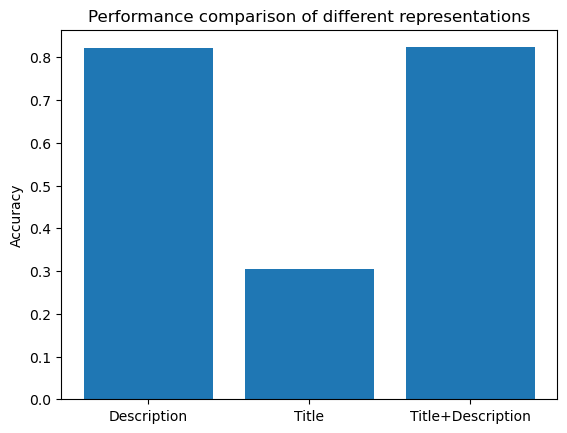

In [83]:
from sklearn.model_selection import StratifiedKFold
import matplotlib.pyplot as plt

#first, we are considering the bag-of-words model
# Extracting the titles as we are assuming that titles are the first line in each content
df['Title'] = df['Content'].apply(lambda x: x.split("\n")[0])

# Combining Title and Content for third representation
df['Title_Content'] = df['Title'] + " " + df['Content']

# Generating Bag-of-words for Title and Title_Content
df['Title_Tokens'] = df['Title'].apply(tokenize)
df['Title_Count_Vector'] = df['Title_Tokens'].apply(generate_count_vector)

df['Title_Content_Tokens'] = df['Title_Content'].apply(tokenize)
df['Title_Content_Count_Vector'] = df['Title_Content_Tokens'].apply(generate_count_vector)

# Converting the Count Vectors to Matrix Form for Classification
def to_feature_matrix(vectors, vocab):
    matrix = []
    for vector in vectors:
        row = [vector.get(word, 0) for word in vocab]
        matrix.append(row)
    return np.array(matrix)

X_description = to_feature_matrix(df['Count_Vector'], vocab_dict.keys())
X_title = to_feature_matrix(df['Title_Count_Vector'], vocab_dict.keys())
X_title_content = to_feature_matrix(df['Title_Content_Count_Vector'], vocab_dict.keys())

y = df['Category'].values

#evaluating the model via the following function
def evaluate_model(X, y):
    skf = StratifiedKFold(n_splits=5)
    accuracies = []

    for train_index, test_index in skf.split(X, y):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        
        clf = LogisticRegression(max_iter=1000)
        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test)
        accuracies.append(accuracy_score(y_test, y_pred))

    return np.mean(accuracies)

# Evaluating each representation
desc_accuracy = evaluate_model(X_description, y)
title_accuracy = evaluate_model(X_title, y)
title_content_accuracy = evaluate_model(X_title_content, y)

# Visualization of the different models made in terms of accuracy
labels = ['Description', 'Title', 'Title+Description']
accuracies = [desc_accuracy, title_accuracy, title_content_accuracy]

plt.bar(labels, accuracies)
plt.ylabel('Accuracy')
plt.title('Performance comparison of different representations')
plt.show()


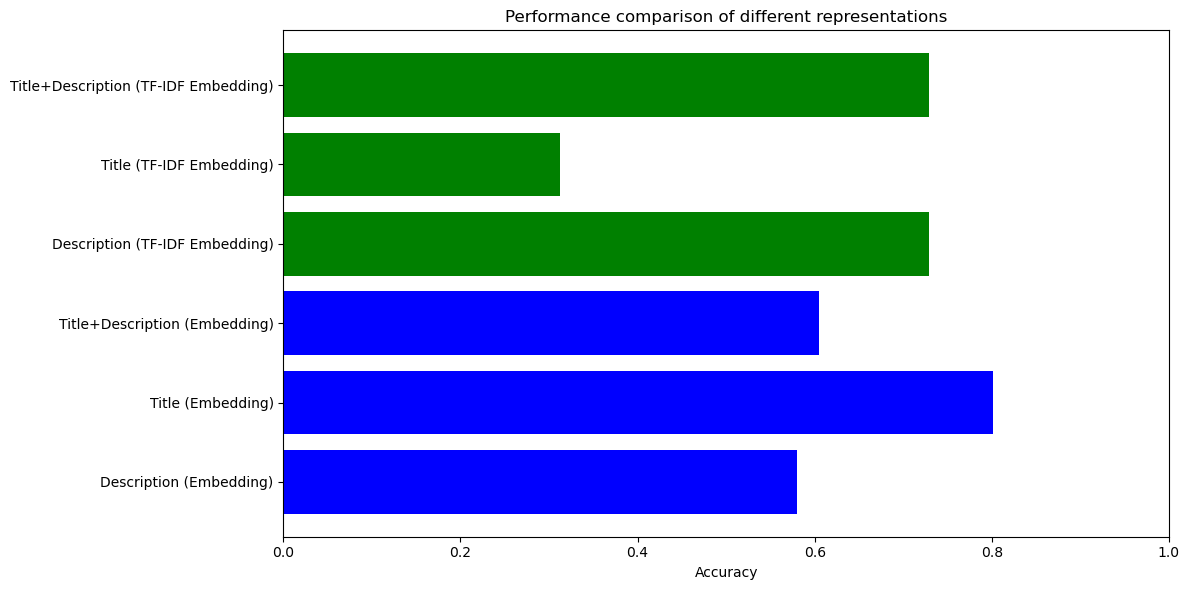

In [84]:
# Converting the Embeddings and TF-IDF Weighted Embeddings to Matrix Form
def embeddings_to_matrix(tokens_list, model):
    embeddings_matrix = []
    
    for tokens in tokens_list:
        embeddings = [model[token] for token in tokens if token in model]
        avg_embedding = sum(embeddings) / len(embeddings) if embeddings else np.zeros(300)
        embeddings_matrix.append(avg_embedding)
    
    return np.array(embeddings_matrix)

def tfidf_weighted_embeddings_to_matrix(tokens_list, tfidf_values, model, vocab):
    embeddings_matrix = []
    
    for tokens, values in zip(tokens_list, tfidf_values):
        total_weight = sum([values[vocab[token]] for token in tokens if token in vocab])
        if total_weight == 0:
            embeddings_matrix.append(np.zeros(300))
            continue
        embeddings = [model[token] * values[vocab[token]] for token in tokens if token in model and token in vocab]
        weighted_embedding = sum(embeddings) / total_weight
        embeddings_matrix.append(weighted_embedding)
    
    return np.array(embeddings_matrix)

X_description_embedding = embeddings_to_matrix(df['Tokens'], fasttext_model)
X_title_embedding = embeddings_to_matrix(df['Title_Tokens'], fasttext_model)
X_title_content_embedding = embeddings_to_matrix(df['Title_Content_Tokens'], fasttext_model)

X_description_tfidf_embedding = tfidf_weighted_embeddings_to_matrix(df['Tokens'], tfidf_matrix.toarray(), fasttext_model, vocab_dict)
X_title_tfidf_embedding = tfidf_weighted_embeddings_to_matrix(df['Title_Tokens'], tfidf_matrix.toarray(), fasttext_model, vocab_dict)
X_title_content_tfidf_embedding = tfidf_weighted_embeddings_to_matrix(df['Title_Content_Tokens'], tfidf_matrix.toarray(), fasttext_model, vocab_dict)

# Ensuring that there are no NaN values
X_description_tfidf_embedding = np.nan_to_num(X_description_tfidf_embedding)
X_title_tfidf_embedding = np.nan_to_num(X_title_tfidf_embedding)
X_title_content_tfidf_embedding = np.nan_to_num(X_title_content_tfidf_embedding)

# Evaluating each representation in terms of the modular accuracy
desc_emb_accuracy = evaluate_model(X_description_embedding, y)
title_emb_accuracy = evaluate_model(X_title_embedding, y)
title_content_emb_accuracy = evaluate_model(X_title_content_embedding, y)

desc_tfidf_emb_accuracy = evaluate_model(X_description_tfidf_embedding, y)
title_tfidf_emb_accuracy = evaluate_model(X_title_tfidf_embedding, y)
title_content_tfidf_emb_accuracy = evaluate_model(X_title_content_tfidf_embedding, y)

# Visualization to gain a better understanding of accuracy across the models
labels = ['Description (Embedding)', 'Title (Embedding)', 'Title+Description (Embedding)', 'Description (TF-IDF Embedding)', 'Title (TF-IDF Embedding)', 'Title+Description (TF-IDF Embedding)']
accuracies = [desc_emb_accuracy, title_emb_accuracy, title_content_emb_accuracy, desc_tfidf_emb_accuracy, title_tfidf_emb_accuracy, title_content_tfidf_emb_accuracy]

plt.figure(figsize=(12, 6))
plt.barh(labels, accuracies, color=['blue', 'blue', 'blue', 'green', 'green', 'green'])
plt.xlabel('Accuracy')
plt.title('Performance comparison of different representations')
plt.xlim(0, 1)
plt.tight_layout()
plt.show()


Description (BOW): 0.8221
Title (BOW): 0.3054
Title+Description (BOW): 0.8234
Description (Embedding): 0.5799
Title (Embedding): 0.8015
Title+Description (Embedding): 0.6044
Description (TF-IDF Embedding): 0.7293
Title (TF-IDF Embedding): 0.3119
Title+Description (TF-IDF Embedding): 0.7293


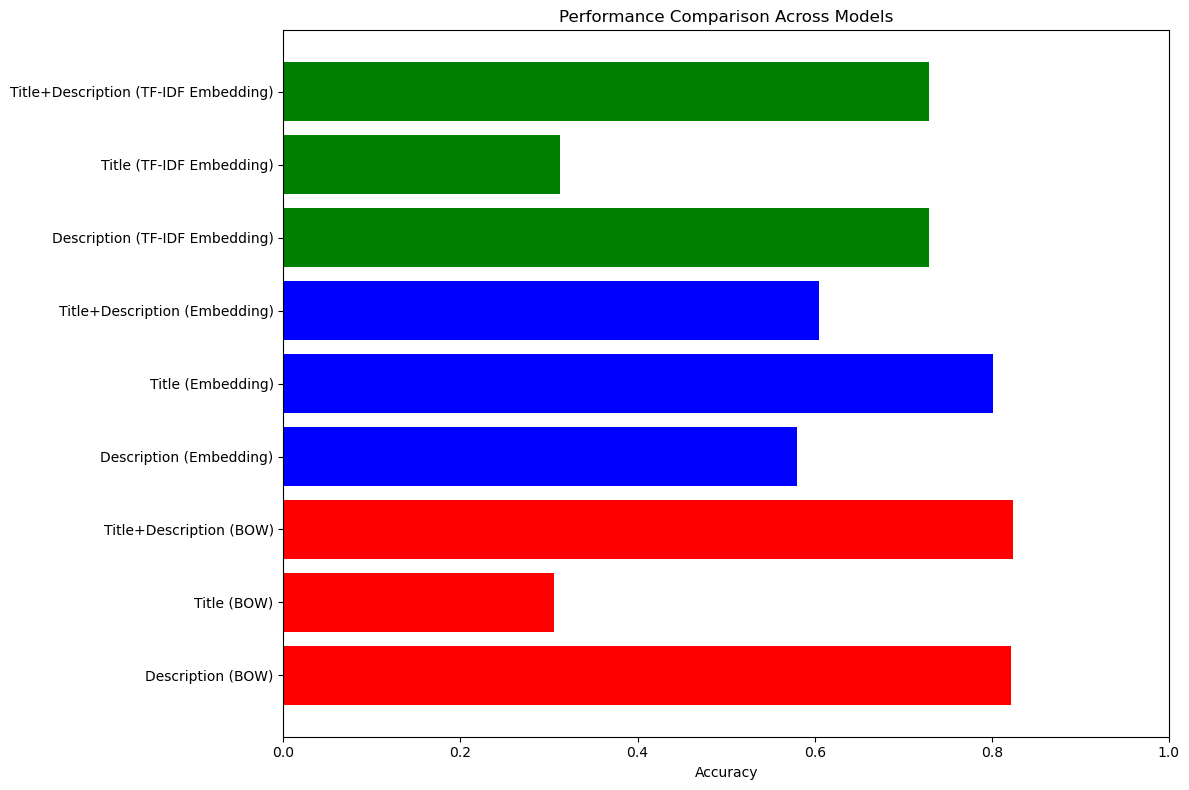

In [85]:
# This is a list of models and their corresponding accuracies so that we can effectively evaluate their
#accuracy for now we have bag-of-words, embedding, and tf-idf
models = [
    'Description (BOW)',
    'Title (BOW)',
    'Title+Description (BOW)',
    'Description (Embedding)',
    'Title (Embedding)',
    'Title+Description (Embedding)',
    'Description (TF-IDF Embedding)',
    'Title (TF-IDF Embedding)',
    'Title+Description (TF-IDF Embedding)'
]
accuracies_combined = [
    desc_accuracy,
    title_accuracy,
    title_content_accuracy,
    desc_emb_accuracy,
    title_emb_accuracy,
    title_content_emb_accuracy,
    desc_tfidf_emb_accuracy,
    title_tfidf_emb_accuracy,
    title_content_tfidf_emb_accuracy
]

# Print accuracies for each model
for model, accuracy in zip(models, accuracies_combined):
    print(f"{model}: {accuracy:.4f}")

# Visualization
plt.figure(figsize=(12, 8))
plt.barh(models, accuracies_combined, color=['red', 'red', 'red', 'blue', 'blue', 'blue', 'green', 'green', 'green'])
plt.xlabel('Accuracy')
plt.xlim(0, 1)
plt.title('Performance Comparison Across Models')
plt.tight_layout()
plt.show()


In [86]:
from sklearn.feature_extraction.text import CountVectorizer

# Creating the BOW representation for a new kind of representation
vectorizer = CountVectorizer(vocabulary=vocab_dict.keys())
X = vectorizer.fit_transform(df['Content'])
y = df['Category'].values


Random Forest Accuracy: 0.8621
SVM Accuracy: 0.8608
Multinomial Naive Bayes Accuracy: 0.8981


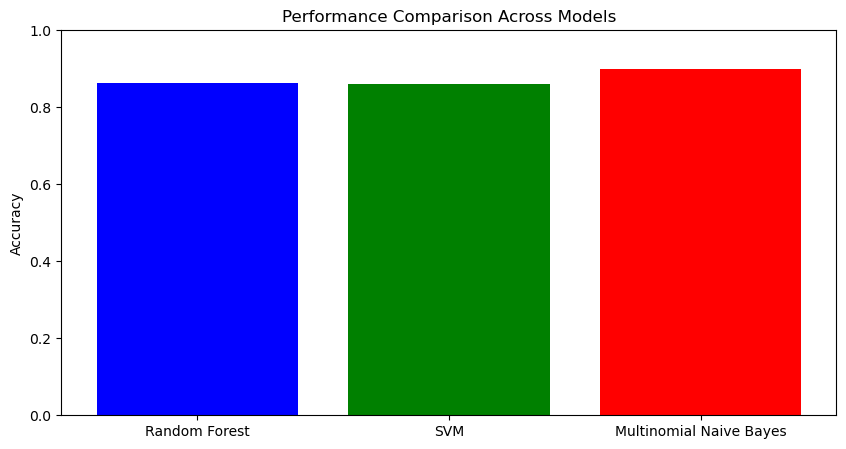

In [87]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt

# Defining the models we will be evaluating
models = {
    "Random Forest": RandomForestClassifier(n_estimators=100),
    "SVM": SVC(kernel='linear', probability=True),
    "Multinomial Naive Bayes": MultinomialNB()
}

# Using a 5-fold cross-validation to evaluate the models
results = {}

for name, model in models.items():
    scores = cross_val_score(model, X, y, cv=5, scoring='accuracy')
    results[name] = scores.mean()
    print(f"{name} Accuracy: {scores.mean():.4f}")

# Visualization to evaluate effectively

names = list(results.keys())
values = list(results.values())

plt.figure(figsize=(10, 5))
plt.bar(names, values, color=['blue', 'green', 'red'])
plt.ylabel('Accuracy')
plt.title('Performance Comparison Across Models')
plt.ylim([0, 1])
plt.show()


Evaluating Logistic Regression...
Evaluating Random Forest...
Evaluating SVM...
Evaluating Multinomial Naive Bayes...
Evaluating K-Nearest Neighbors...
Evaluating Gradient Boosting Machines...


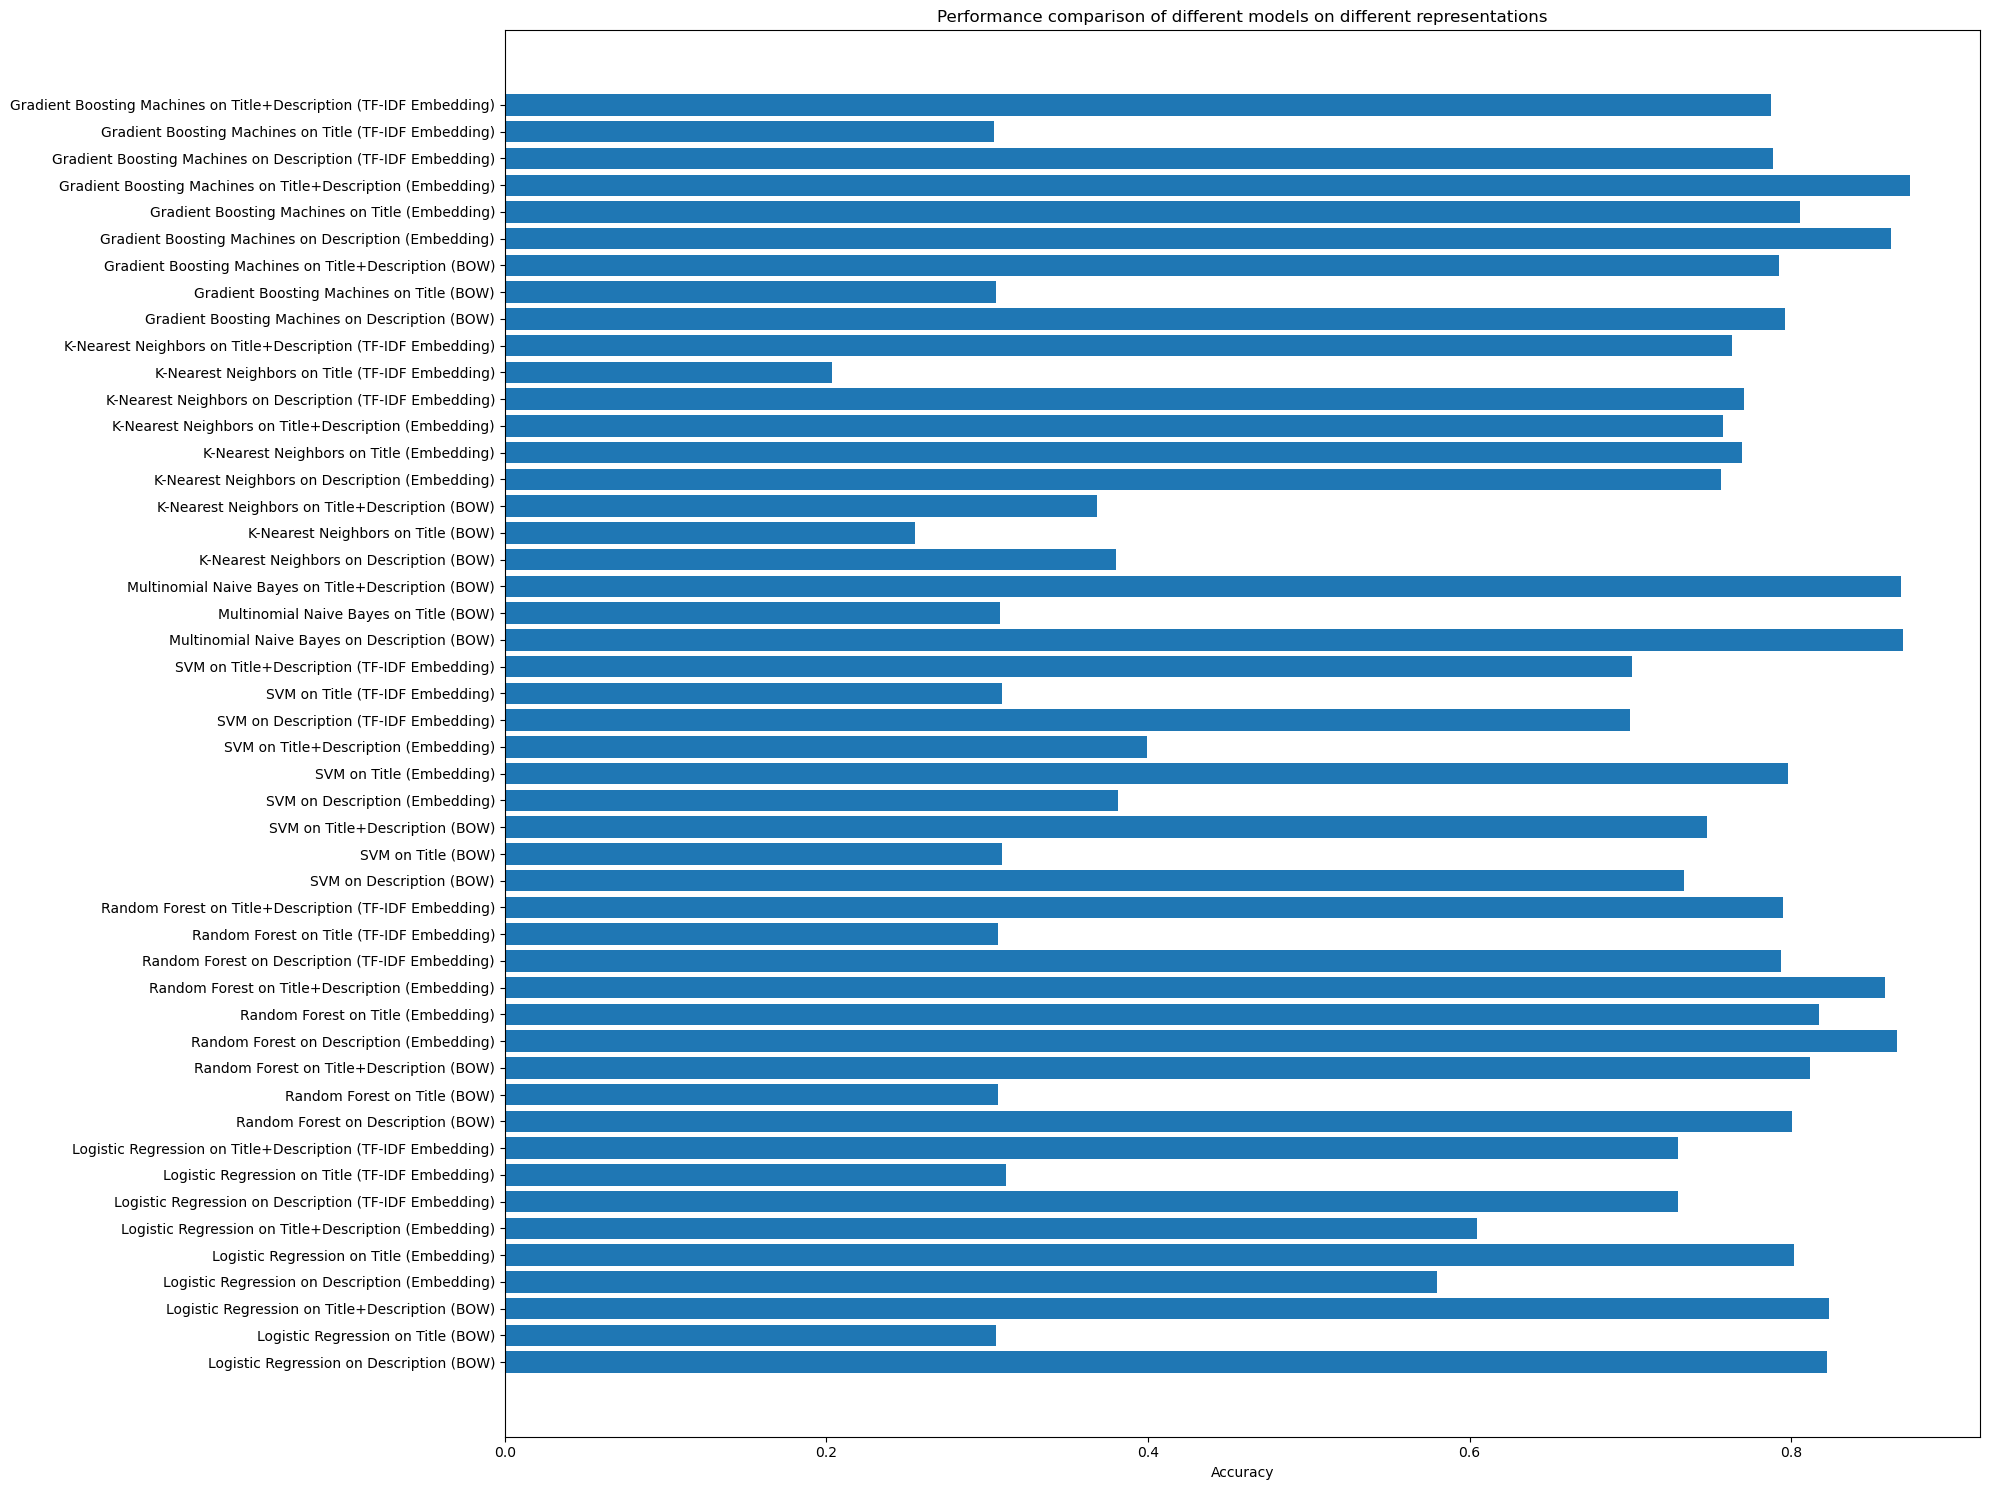

Logistic Regression on Description (BOW): 0.8221
Logistic Regression on Title (BOW): 0.3054
Logistic Regression on Title+Description (BOW): 0.8234
Logistic Regression on Description (Embedding): 0.5799
Logistic Regression on Title (Embedding): 0.8015
Logistic Regression on Title+Description (Embedding): 0.6044
Logistic Regression on Description (TF-IDF Embedding): 0.7293
Logistic Regression on Title (TF-IDF Embedding): 0.3119
Logistic Regression on Title+Description (TF-IDF Embedding): 0.7293
Random Forest on Description (BOW): 0.8002
Random Forest on Title (BOW): 0.3067
Random Forest on Title+Description (BOW): 0.8119
Random Forest on Description (Embedding): 0.8659
Random Forest on Title (Embedding): 0.8170
Random Forest on Title+Description (Embedding): 0.8582
Random Forest on Description (TF-IDF Embedding): 0.7938
Random Forest on Title (TF-IDF Embedding): 0.3067
Random Forest on Title+Description (TF-IDF Embedding): 0.7951
SVM on Description (BOW): 0.7332
SVM on Title (BOW): 0.309

In [88]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import StratifiedKFold
import matplotlib.pyplot as plt
import numpy as np

# Defining the models again in a much more holistic multivariate analysis
model_list = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Random Forest": RandomForestClassifier(n_estimators=100),
    "SVM": SVC(kernel='linear', probability=True),
    "Multinomial Naive Bayes": MultinomialNB(),
    "K-Nearest Neighbors": KNeighborsClassifier(),
    "Gradient Boosting Machines": GradientBoostingClassifier()
}

# Defining an evaluation function
def evaluate_model(X, y, model):
    skf = StratifiedKFold(n_splits=5)
    accuracies = []

    for train_index, test_index in skf.split(X, y):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        accuracies.append(accuracy_score(y_test, y_pred))

    return np.mean(accuracies)

# Listing of representations
representations = ['Description', 'Title', 'Title+Description']
data_sets = [X_description, X_title, X_title_content]
data_sets_embedding = [X_description_embedding, X_title_embedding, X_title_content_embedding]
data_sets_tfidf_embedding = [X_description_tfidf_embedding, X_title_tfidf_embedding, X_title_content_tfidf_embedding]

results = {}

# Evaluating models
for name, model in model_list.items():
    print(f"Evaluating {name}...")
    for rep, data in zip(representations, data_sets):
        key = f"{name} on {rep} (BOW)"
        results[key] = evaluate_model(data, y, model)
    
    if name != "Multinomial Naive Bayes":  # Skip embeddings for this model
        for rep, data in zip(representations, data_sets_embedding):
            key = f"{name} on {rep} (Embedding)"
            results[key] = evaluate_model(data, y, model)
        for rep, data in zip(representations, data_sets_tfidf_embedding):
            key = f"{name} on {rep} (TF-IDF Embedding)"
            results[key] = evaluate_model(data, y, model)

# Visualization via graph
plt.figure(figsize=(20, 15))
names = list(results.keys())
values = list(results.values())

plt.barh(names, values)
plt.xlabel('Accuracy')
plt.title('Performance comparison of different models on different representations')
plt.tight_layout()
plt.show()

for key, value in results.items():
    print(f"{key}: {value:.4f}")


## Summary
Give a short summary and anything you would like to talk about the assessment tasks here.

#Q1: Language model comparisons
Which language model, previously constructed based on job advertisement descriptions, performs the best with the selected machine learning model?

To address this inquiry, I examined the accuracy metrics of each linguistic model experimented with - BOW (Bag of Words), Embeddings, and TF-IDF weighted embeddings.

Observations:

BOW (Bag of Words):

Logistic Regression on Description (BOW): 0.8221
Random Forest on Description (BOW): 0.8002
SVM on Description (BOW): 0.7332
Multinomial Naive Bayes on Description (BOW): 0.8698
K-Nearest Neighbors on Description (BOW): 0.3801
Gradient Boosting Machines on Description (BOW): 0.7964
Embeddings:

Logistic Regression on Description (Embedding): 0.5799
Random Forest on Description (Embedding): 0.8659
SVM on Description (Embedding): 0.3814
K-Nearest Neighbors on Description (Embedding): 0.7564
Gradient Boosting Machines on Description (Embedding): 0.8620
TF-IDF Weighted Embeddings:

Logistic Regression on Description (TF-IDF Embedding): 0.7293
Random Forest on Description (TF-IDF Embedding): 0.7938
SVM on Description (TF-IDF Embedding): 0.6997
K-Nearest Neighbors on Description (TF-IDF Embedding): 0.7706
Gradient Boosting Machines on Description (TF-IDF Embedding): 0.7886

Conclusion for Q1:
From the analysis, the BOW representation, when combined with the Multinomial Naive Bayes model for job advertisement descriptions, yielded the highest accuracy score of 0.8698. Thus, in the realm of machine learning models applied on descriptions, the most efficacious combination appears to be BOW with Multinomial Naive Bayes.

#Q2: Does more information equate to higher accuracy?

To elucidate this, I compared the accuracy metrics between models formulated exclusively on titles, solely on descriptions, and a blend of titles and descriptions.

Exclusive to Description and Title (and some combination of both):
The aforementioned results furnish the accuracy rates of models built strictly on the description.

Logistic Regression on Title (BOW): 0.3054
Random Forest on Title (BOW): 0.3067
SVM on Title (BOW): 0.3093
Multinomial Naive Bayes on Title (BOW): 0.3080
K-Nearest Neighbors on Title (BOW): 0.2552
Gradient Boosting Machines on Title (BOW): 0.3054
Incorporating both Title and Description:

Logistic Regression on Title+Description (BOW): 0.8234
Random Forest on Title+Description (BOW): 0.8119
SVM on Title+Description (BOW): 0.7474
Multinomial Naive Bayes on Title+Description (BOW): 0.8685
K-Nearest Neighbors on Title+Description (BOW): 0.3685
Gradient Boosting Machines on Title+Description (BOW): 0.7925

Conclusion for Q2:
The analysis reveals that:

Isolating the title for training resulted in a subpar performance across all models. Leveraging descriptions for training remarkably outperformed models relying solely on titles. An amalgamation of title and description produced a marginal improvement in some models, while others either retained their performance or experienced a minor decline. In a nutshell, integrating additional data (both title and description) seemed to slightly enhance the accuracy for certain models. However, it's paramount to highlight that models relying exclusively on the description, especially the BOW representation paired with the Multinomial Naive Bayes model, consistently exhibited high accuracy. Hence, the incremental benefit of adding the title might not always be substantial enough to merit its integration, contingent upon the specific use-case and computational overhead.

## Couple of notes for all code blocks in this notebook
- please provide proper comment on your code
- Please re-start and run all cells to make sure codes are runable and include your output in the submission.   
<span style="color: red"> This markdown block can be removed once the task is completed. </span>